In [19]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load pre-trained RuBERT model for Russian texts
model_name = "sberbank-ai/ruBert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # Binary classification: signal / no signal

# Dataset class for loading news data
class NewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoded = tokenizer(self.texts[idx], truncation=True, padding='max_length', max_length=128, return_tensors='pt')
        return {
            'input_ids': encoded['input_ids'].squeeze(),
            'attention_mask': encoded['attention_mask'].squeeze(),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Training function with validation and metrics tracking
def train_model(model, train_loader, val_loader, epochs=3):
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    loss_fn = nn.CrossEntropyLoss()
    model.train()

    train_losses = []
    val_losses = []
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1s = []

    for epoch in range(epochs):
        total_train_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch in progress_bar:
            optimizer.zero_grad()
            outputs = model(input_ids=batch['input_ids'],
                            attention_mask=batch['attention_mask'],
                            labels=batch['label'])
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1} completed. Train Loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        total_val_loss = 0
        val_preds = []
        val_labels = []
        with torch.no_grad():
            for batch in val_loader:
                outputs = model(input_ids=batch['input_ids'],
                                attention_mask=batch['attention_mask'],
                                labels=batch['label'])
                loss = outputs.loss
                logits = outputs.logits
                total_val_loss += loss.item()

                preds = torch.argmax(logits, dim=1).cpu().numpy()
                labels = batch['label'].cpu().numpy()
                val_preds.extend(preds)
                val_labels.extend(labels)

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        accuracy = accuracy_score(val_labels, val_preds)
        precision = precision_score(val_labels, val_preds, zero_division=0)
        recall = recall_score(val_labels, val_preds, zero_division=0)
        f1 = f1_score(val_labels, val_preds, zero_division=0)

        val_accuracies.append(accuracy)
        val_precisions.append(precision)
        val_recalls.append(recall)
        val_f1s.append(f1)

        print(f"Validation - Loss: {avg_val_loss:.4f}, Acc: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
        model.train()

    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_losses, marker='o', label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, marker='o', label='Validation Loss')
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Plot validation metrics
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), val_accuracies, marker='o', label='Accuracy')
    plt.plot(range(1, epochs+1), val_precisions, marker='o', label='Precision')
    plt.plot(range(1, epochs+1), val_recalls, marker='o', label='Recall')
    plt.plot(range(1, epochs+1), val_f1s, marker='o', label='F1-score')
    plt.title("Validation Metrics per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
import pandas as pd

# Correct file path (using raw string or double slashes)
file_path = r"C:\Users\Карпенко\ВКР Карпенко\model\filtered_interfax_data.xlsx"

# Load data
df = pd.read_excel(file_path)
print(df)

                     Дата                                              Текст  \
0     2025-01-30 16:23:07  🔺**Минюст РФ зарегистрировал указание о повыше...   
1     2025-01-30 16:04:54  🛢**Brent подорожала до $77,35 за баррель**\n\n...   
2     2025-01-30 16:01:07  **🇷🇺Рынок акций РФ поднялся к 2970п по индексу...   
3     2025-01-30 14:35:27  💵💶**Официальные курсы ЦБ РФ с 31 января - 98,0...   
4     2025-01-30 13:38:04  **ЦБ и Мосбиржа запускают программу создания а...   
...                   ...                                                ...   
1514  2025-04-01 06:36:27  🛒**ГК "О'Кей" в 2024 году увеличила EBITDA на ...   
1515  2025-04-01 06:11:33  **🔻Индекс PMI обрабатывающих отраслей РФ в мар...   
1516  2025-04-01 06:05:38  **ЦБ РФ ввел категорию инвесторов с начальным ...   
1517  2025-04-01 05:56:12  🛢**Brent подорожала до $74,92 за баррель**\n\n...   
1518  2025-04-01 05:47:06  🇺🇸**Фондовые индексы США не показали единой ди...   

      Label  
0       0.0  
1       0.0

In [3]:
invalid_rows = df[df['Текст'].isnull() | (df['Текст'].apply(lambda x: not isinstance(x, str)))]

print(f"Найдено {len(invalid_rows)} строк, которые могут вызвать ошибку.")
print(invalid_rows[['Дата', 'Текст']].head(10))

Найдено 2 строк, которые могут вызвать ошибку.
                     Дата Текст
68    2025-01-27 07:48:28   NaN
1176  2025-04-24 07:06:34   NaN


In [4]:
df_cleaned = df[df['Текст'].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0)]
df_cleaned

,Дата,Текст,Label
0,2025-01-30 16:23:07,🔺**Минюст РФ зарегистрировал указание о повыше...,0.0
1,2025-01-30 16:04:54,"🛢**Brent подорожала до $77,35 за баррель**\n\n...",0.0
2,2025-01-30 16:01:07,**🇷🇺Рынок акций РФ поднялся к 2970п по индексу...,0.0
3,2025-01-30 14:35:27,"💵💶**Официальные курсы ЦБ РФ с 31 января - 98,0...",0.0
4,2025-01-30 13:38:04,**ЦБ и Мосбиржа запускают программу создания а...,0.0
...,...,...,...
1514,2025-04-01 06:36:27,"🛒**ГК ""О'Кей"" в 2024 году увеличила EBITDA на ...",1.0
1515,2025-04-01 06:11:33,**🔻Индекс PMI обрабатывающих отраслей РФ в мар...,0.0
1516,2025-04-01 06:05:38,**ЦБ РФ ввел категорию инвесторов с начальным ...,0.0
1517,2025-04-01 05:56:12,"🛢**Brent подорожала до $74,92 за баррель**\n\n...",0.0


Epoch 1/3: 100%|████████████████████████████████████████████████████████| 152/152 [13:59<00:00,  5.52s/it, loss=0.0613]


Epoch 1 completed. Train Loss: 0.2187
Validation - Loss: 0.1110, Acc: 0.9671, Precision: 0.9529, Recall: 0.9310, F1: 0.9419


Epoch 2/3: 100%|██████████████████████████████████████████████████████████| 152/152 [13:30<00:00,  5.33s/it, loss=1.14]


Epoch 2 completed. Train Loss: 0.0969
Validation - Loss: 0.1939, Acc: 0.9474, Precision: 0.9733, Recall: 0.8391, F1: 0.9012


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 152/152 [13:17<00:00,  5.25s/it, loss=0.00525]


Epoch 3 completed. Train Loss: 0.0572
Validation - Loss: 0.1358, Acc: 0.9638, Precision: 0.9318, Recall: 0.9425, F1: 0.9371


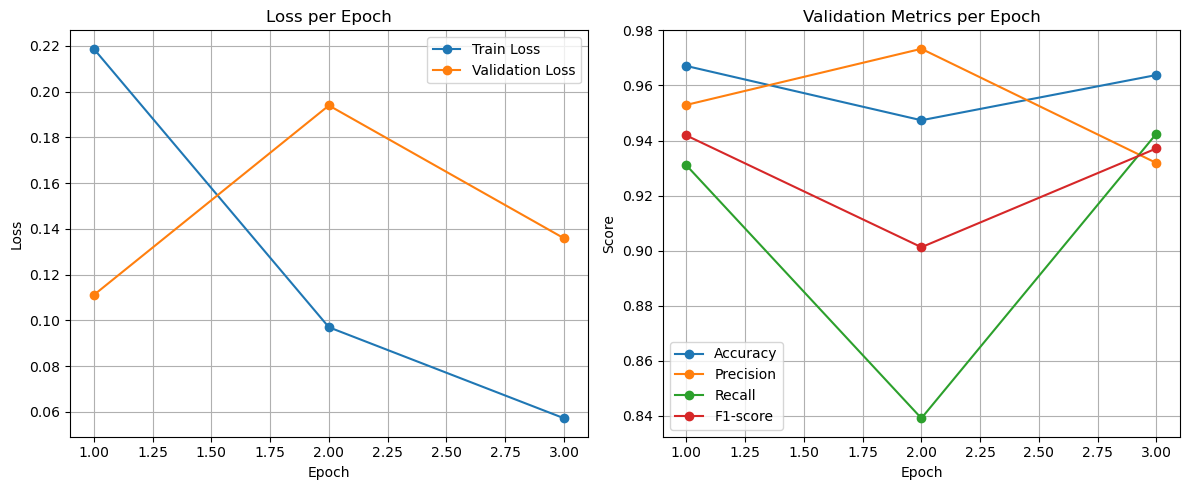

In [6]:
from sklearn.model_selection import train_test_split

# Prepare data
texts = df_cleaned['Текст'].dropna().astype(str).tolist()
labels = df_cleaned['Label'].tolist()

# Split data into train and validation
texts_train, texts_val, labels_train, labels_val = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Create datasets and loaders
train_dataset = NewsDataset(texts_train, labels_train)
val_dataset = NewsDataset(texts_val, labels_val)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Train model
train_model(model, train_loader, val_loader, epochs=3)

In [12]:
test_text = """
"Озон Фармацевтика" в I квартале увеличила чистую прибыль по МСФО на 28%

ПАО "Озон Фармацевтика" (Тольятти, Самарская область) в январе-марте 2025 года увеличило чистую прибыль по МСФО на 28% по сравнению с показателем аналогичного периода 2024 года - до 993 млн рублей, говорится в отчете компании.

Выручка компании выросла на 45% год к году, до 6,855 млрд рублей, операционная прибыль - на 70%, до 2,2 млрд рублей. Рентабельность по операционной прибыли увеличилась на 4,7 п.п., до 32,2%.

EBITDA увеличилась на 60,3% и достигла 2,4 млрд рублей, скорректированная EBITDA возросла на 61% г/г до 2,5 млрд рублей, рентабельность по скорректированной EBITDA увеличилась на 3,6 п.п., до 36%.

Рентабельность по чистой прибыли снизилась на 1,9 п.п. и составила 14,5% в основном из-за роста чистых финансовых расходов (после присоединения ООО "Мабскейл").

Соотношение чистый долг/EBITDA за предшествующие 12 месяцев сохранилось на уровне 1,1х.

"""

inputs = tokenizer(test_text, truncation=True, padding='max_length', max_length=128, return_tensors='pt')

model.eval()

with torch.no_grad():
    outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

if predicted_class == 1:
    print("🌟 Модель считает, что это СИГНАЛ.")
else:
    print("✅ Модель считает, что это НЕ СИГНАЛ.")


🌟 Модель считает, что это СИГНАЛ.


In [10]:
error_texts = []
error_true_labels = []
error_pred_labels = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for batch in val_loader:
        outputs = model(input_ids=batch['input_ids'],
                        attention_mask=batch['attention_mask'],
                        labels=batch['label'])
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        true_labels = batch['label'].cpu().numpy()

        # Look for misclassified examples
        for i in range(len(preds)):
            if preds[i] != true_labels[i]:
                error_texts.append(batch['input_ids'][i])  
                error_true_labels.append(true_labels[i])
                error_pred_labels.append(preds[i])

# Decode misclassified text samples (using tokenizer)
decoded_errors = [tokenizer.decode(ids, skip_special_tokens=True) for ids in error_texts]

for text, true_label, pred_label in zip(decoded_errors, error_true_labels, error_pred_labels):
    print(f"\nText: {text}\nTrue Label: {true_label}, Predicted Label: {pred_label}")



Text: * * мосбиржа включит акции " озон фармацевтики " в сектор рии * * московская биржа приняла решение с 7 февраля включить обыкновенные акции пао " озон фармацевтика " в сектор рынка инновации и инвестиции ( рии ), говорится в сообщении торговои площадки. в конце января биржа перевела акции компании из первого во второи уровень листинга. рынок инновации и инвестиции - биржевая площадка, созданная мосбиржеи и " роснано " для привлечения инвестиции в компании инновационных секторов россиискои экономики. для включения в этот сектор компании должны соответствовать ряду требовании. сеичас в нем состоят акции таких
True Label: 1, Predicted Label: 0

Text: * * " цифровые привычки " разместили 30 млн акции в рамках pre - ipo по цене 30 руб. за бумагу * * ао " цифровые привычки " ( группа компании, занимающаяся разработкои решении и предоставлением ит - услуг в области финтеха ) разместило 30 млн акции ( около 17 % уставного капитала ) в рамках pre - ipo, говорится в сообщении компании. фак

In [14]:
save_path = "trained_model1_weights.pth"
torch.save(model.state_dict(), save_path)
print(f"The model has been successfully saved to a file: {save_path}")

The model has been successfully saved to a file: trained_model1_weights.pth


## Cross-Validation

In [16]:
import numpy as np
from sklearn.model_selection import StratifiedKFold


texts = df_cleaned['Текст'].dropna().astype(str).tolist()
labels = df_cleaned['Label'].tolist()

# Custom Dataset class
class NewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoded = tokenizer(self.texts[idx], truncation=True, padding='max_length', max_length=128, return_tensors='pt')
        return {
            'input_ids': encoded['input_ids'].squeeze(),
            'attention_mask': encoded['attention_mask'].squeeze(),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

model_name = "sberbank-ai/ruBert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Parameters
k_folds = 5
batch_size = 8
epochs = 3
learning_rate = 2e-5

all_accuracies = []
all_precisions = []
all_recalls = []
all_f1s = []

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
    print(f"\n🔎 Fold {fold+1}/{k_folds}")
    train_texts = [texts[i] for i in train_idx]
    val_texts = [texts[i] for i in val_idx]
    train_labels = [labels[i] for i in train_idx]
    val_labels = [labels[i] for i in val_idx]

    train_dataset = NewsDataset(train_texts, train_labels)
    val_dataset = NewsDataset(val_texts, val_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Load a fresh model for each fold
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()

    # Training loop
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Fold {fold+1} - Epoch {epoch+1}/{epochs}")
        for batch in progress_bar:
            optimizer.zero_grad()
            outputs = model(input_ids=batch['input_ids'],
                            attention_mask=batch['attention_mask'],
                            labels=batch['label'])
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

    # Validation loop
    model.eval()
    val_preds = []
    val_true = []
    with torch.no_grad():
        for batch in val_loader:
            outputs = model(input_ids=batch['input_ids'],
                            attention_mask=batch['attention_mask'],
                            labels=batch['label'])
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels_batch = batch['label'].cpu().numpy()
            val_preds.extend(preds)
            val_true.extend(labels_batch)

    # Calculate metrics for the fold
    acc = accuracy_score(val_true, val_preds)
    prec = precision_score(val_true, val_preds, zero_division=0)
    rec = recall_score(val_true, val_preds, zero_division=0)
    f1 = f1_score(val_true, val_preds, zero_division=0)

    print(f"Fold {fold+1} - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

    all_accuracies.append(acc)
    all_precisions.append(prec)
    all_recalls.append(rec)
    all_f1s.append(f1)

    # Save the model from the last fold
    if fold == k_folds - 1:
        save_path = "final_model_weights_after_kfold.pth"
        torch.save(model.state_dict(), save_path)
        print(f"✅ Model saved after {k_folds}-fold cross-validation: {save_path}")

# Print average metrics across all folds
print("\n📊 Average Results across Folds:")
print(f"Accuracy: {np.mean(all_accuracies):.4f}")
print(f"Precision: {np.mean(all_precisions):.4f}")
print(f"Recall: {np.mean(all_recalls):.4f}")
print(f"F1: {np.mean(all_f1s):.4f}")




🔎 Fold 1/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fold 1 - Epoch 3/3: 100%|███████████████████████████████████████████████| 152/152 [09:34<00:00,  3.78s/it, loss=0.0073]


Fold 1 - Accuracy: 0.9572, Precision: 0.9091, Recall: 0.9211, F1: 0.9150

🔎 Fold 2/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fold 2 - Epoch 3/3: 100%|██████████████████████████████████████████████| 152/152 [07:44<00:00,  3.05s/it, loss=0.00323]


Fold 2 - Accuracy: 0.9704, Precision: 0.9351, Recall: 0.9474, F1: 0.9412

🔎 Fold 3/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fold 3 - Epoch 3/3: 100%|██████████████████████████████████████████████| 152/152 [07:15<00:00,  2.86s/it, loss=0.00626]


Fold 3 - Accuracy: 0.9571, Precision: 0.9079, Recall: 0.9200, F1: 0.9139

🔎 Fold 4/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fold 4 - Epoch 3/3: 100%|██████████████████████████████████████████████| 152/152 [07:19<00:00,  2.89s/it, loss=0.00695]


Fold 4 - Accuracy: 0.9373, Precision: 0.9130, Recall: 0.8289, F1: 0.8690

🔎 Fold 5/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fold 5 - Epoch 3/3: 100%|███████████████████████████████████████████████| 152/152 [07:24<00:00,  2.92s/it, loss=0.0277]


Fold 5 - Accuracy: 0.9604, Precision: 0.8721, Recall: 0.9868, F1: 0.9259
✅ Model saved after 5-fold cross-validation: final_model_weights_after_kfold.pth

📊 Average Results across Folds:
Accuracy: 0.9565
Precision: 0.9074
Recall: 0.9208
F1: 0.9130


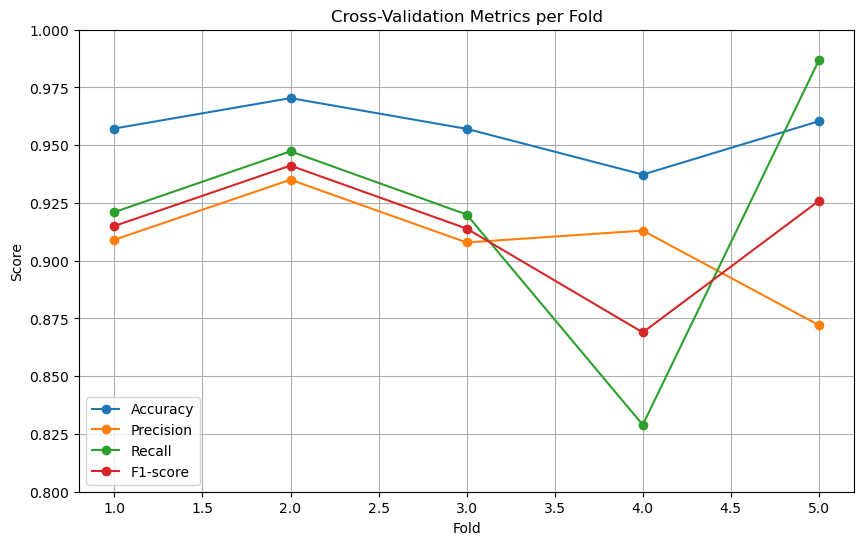

In [18]:
import matplotlib.pyplot as plt

folds = list(range(1, k_folds + 1))

plt.figure(figsize=(10, 6))

plt.plot(folds, all_accuracies, marker='o', label='Accuracy')
plt.plot(folds, all_precisions, marker='o', label='Precision')
plt.plot(folds, all_recalls, marker='o', label='Recall')
plt.plot(folds, all_f1s, marker='o', label='F1-score')

plt.title("Cross-Validation Metrics per Fold")
plt.xlabel("Fold")
plt.ylabel("Score")
plt.ylim(0.8, 1)  
plt.legend()
plt.grid(True)
plt.show()


## Check model DeepPavlov/rubert-base-cased

C:\Games\123\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Ольга\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3: 100%|█████████████████████████████████████████████████████████| 152/152 [07:43<00:00,  3.05s/it, loss=0.381]


Epoch 1 completed. Train Loss: 0.2523
Validation - Loss: 0.1615, Acc: 0.9439, Precision: 0.8642, Recall: 0.9211, F1: 0.8917


Epoch 2/3: 100%|█████████████████████████████████████████████████████████| 152/152 [07:54<00:00,  3.12s/it, loss=0.666]


Epoch 2 completed. Train Loss: 0.1050
Validation - Loss: 0.1296, Acc: 0.9637, Precision: 0.8916, Recall: 0.9737, F1: 0.9308


Epoch 3/3: 100%|█████████████████████████████████████████████████████████| 152/152 [07:56<00:00,  3.14s/it, loss=0.336]


Epoch 3 completed. Train Loss: 0.0677
Validation - Loss: 0.1389, Acc: 0.9538, Precision: 0.9189, Recall: 0.8947, F1: 0.9067


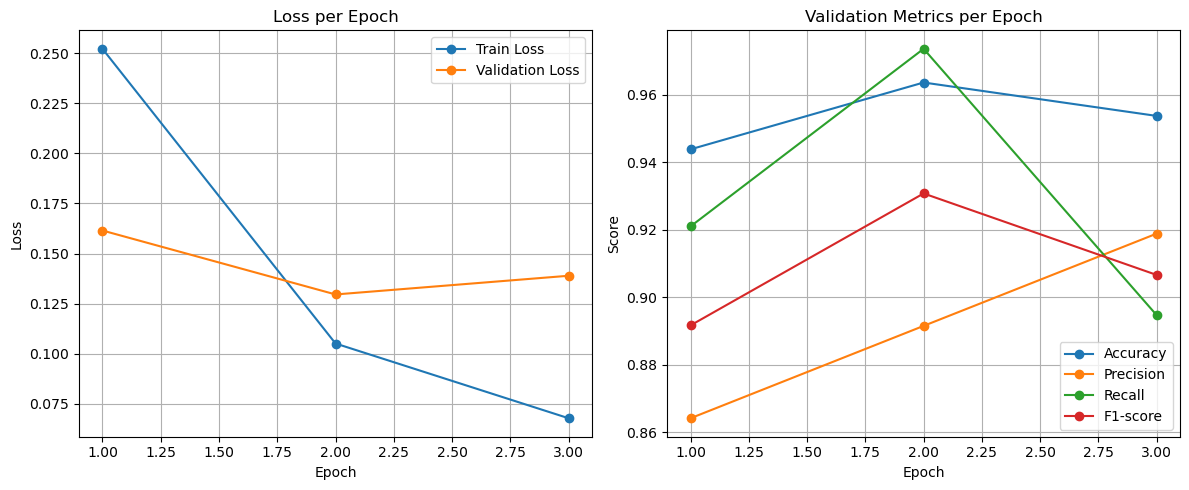

In [20]:
model_name = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

train_model(model, train_loader, val_loader, epochs=3)

## Logistic Regression

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

texts = df_cleaned['Текст'].dropna().astype(str).tolist()
labels = df_cleaned['Label'].tolist()

texts_train, texts_val, labels_train, labels_val = train_test_split(texts, labels, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(texts_train)
X_val = vectorizer.transform(texts_val)

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, labels_train)

val_preds = lr_model.predict(X_val)

accuracy = accuracy_score(labels_val, val_preds)
precision = precision_score(labels_val, val_preds, zero_division=0)
recall = recall_score(labels_val, val_preds, zero_division=0)
f1 = f1_score(labels_val, val_preds, zero_division=0)

print(f"\n📊 Logistic Regression Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1: {f1:.4f}")


📊 Logistic Regression Results:
Accuracy: 0.9309
Precision: 0.9583
Recall: 0.7931
F1: 0.8679


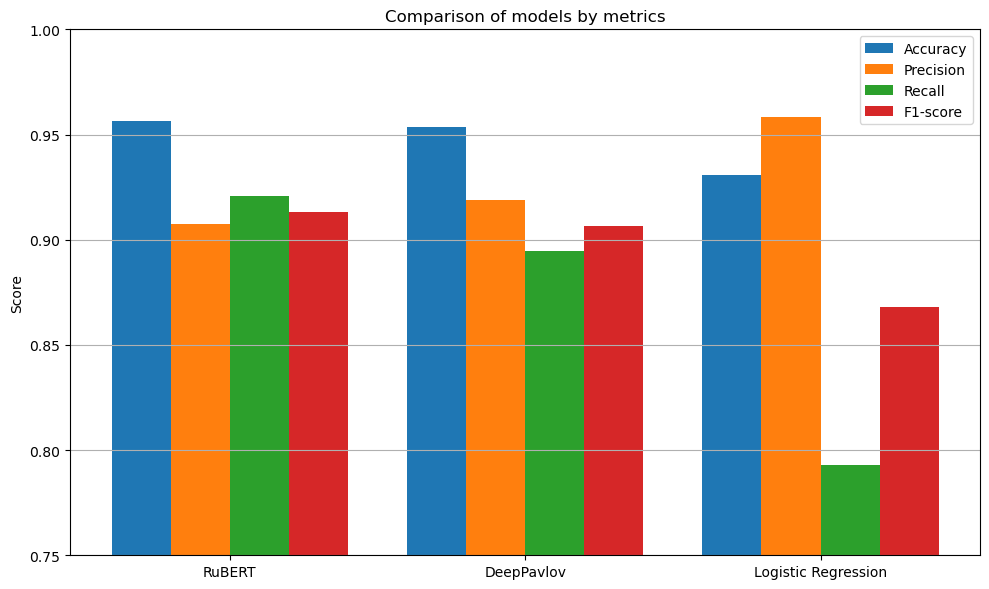

In [24]:
import matplotlib.pyplot as plt
import numpy as np

models = ['RuBERT', 'DeepPavlov', 'Logistic Regression']
accuracies = [0.9565, 0.9538, 0.9309]
precisions = [0.9074, 0.9189, 0.9583]
recalls = [0.9208, 0.8947, 0.7931]
f1_scores = [0.9130, 0.9067, 0.8679]

x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(10, 6))
plt.bar(x - 1.5*width, accuracies, width, label='Accuracy')
plt.bar(x - 0.5*width, precisions, width, label='Precision')
plt.bar(x + 0.5*width, recalls, width, label='Recall')
plt.bar(x + 1.5*width, f1_scores, width, label='F1-score')

plt.ylabel('Score')
plt.ylim(0.75, 1.0)
plt.title('Comparison of models by metrics')
plt.xticks(x, models)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()
